In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser
import datetime
import nltk
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import re

Sentiment Analyzer

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

Build Helper Functions

In [5]:
import sys
def printprogress(i,imax):
    sys.stdout.write('\r');sys.stdout.write("[%-10s] %d%%" % ('='*round(i*10.0/imax), i*100.0/imax))
    sys.stdout.flush()
def sentiment(doc):
    total_length = len(''.join(doc))
    com = 0
    for sentence in doc:
        ss = sid.polarity_scores(sentence)
        com += ss['compound']*len(sentence)/total_length
    return com
def emotion(doc):
    doc = ' '.join(doc)
    texts = [lexdict[w] for w in re.sub("[^\w]", " ", doc).split() if w in wordlist]
    total_length = len(texts)
    if total_length == 0:
        return 0.0,0.0,0.0,0.0
    else:
        scores = np.sum(texts,0)/total_length
    return scores[0], scores[3], scores[4], scores[7]
def stdrdz(x):
    return (x-np.mean(x))/np.std(x)
def bestfit(trace):
    xfit = list(np.linspace(min(trace['x']),max(trace['x']),10))
    yfit = list(np.poly1d(np.polyfit(trace['x'], trace['y'], 1))(xfit))
    trace_fit = go.Scatter(
                    x = xfit,
                    y = yfit,
                    name = 'line-of-best-fit: '+ trace['name'],
                    line = dict(
                        color = (trace['color']),
                        width = 3),
                        mode='lines')

In [6]:
def getsender(df,key):
    return df.loc[df.sender == key,:]
def getthread(df,key):
    return df.loc[df.thread == key,:]
def searchtext(df,key):
    indexlist = [i for i in range(len(df.iloc[:,1])) if str.upper(key) in str.upper(df.iloc[i,:].text)]
    return df.iloc[indexlist,:]
def searchsender(df,key):
    return [s for s in set(list(df.sender)) if key.upper() in s.upper()]
def searchthread(df,key):
    return [s for s in set(list(df.thread)) if key.upper() in s.upper()]
def timeseries(df,W,rolling=False):
    df.loc[:,'time'] = pd.to_datetime(df.loc[:,'time'])
    df.sort_values('time',inplace=True)
    out = []; i = 0; t = df.iloc[0,2]+datetime.timedelta(W/2)
    while t < df.iloc[-1,2]:
        if rolling:
            imax = (df.iloc[-1,2]-df.iloc[0,2]).days; dt = 1
        else:
            imax = (df.iloc[-1,2]-df.iloc[0,2]).days/W; dt = W
        dfwindow = df[(df.time <= t) & (df.time > t-datetime.timedelta(W))]
        freq = len(dfwindow)
        text = [msg for msg in list(dfwindow.text) if len(msg)>10]
        senti = sentiment(text)
        anger,fear,joy,sad = emotion(text)
        out.append([t, freq, text, senti, anger, fear, joy, sad])
        printprogress(i,imax)
        i += 1; t += datetime.timedelta(dt)
    dfout = pd.DataFrame.from_records(out)
    dfout.columns=['time','n_msgs','text','com','anger','fear','joy','sadness']
    return dfout

Emotion Lexicon

In [8]:
lex = pd.DataFrame.from_csv('lexicon.txt',sep='\t',header=None, index_col= None, encoding = "ISO-8859-1")
lex.columns = ['word','emotion','score'];
wordlist = set(lex.word)

In [7]:
lexdict = {}
for i,w in enumerate(wordlist):
    lexdict[w] = lex[lex.word == w].score
    printprogress(i,len(wordlist))

[==========] 99%

Load Message DataFrame

In [9]:
dfmain = pd.DataFrame.from_csv('out.csv',header=None, index_col=None, encoding = "ISO-8859-1")
dfmain.columns = ['thread','sender','time','text']
dfmain = dfmain.astype(str)

## Fight Onset

In [13]:
bg = timeseries(getthread(dfmain,'Grace Arabian'),1);

[==========] 100%

In [15]:
bg.head()

,time,n_msgs,text,com,anger,fear,joy,sadness
0,2011-07-17 19:11:00,35,"[wow you're up?, or is this a message, why ar ...",0.027014,0.0,0.0,0.090909,0.0
1,2011-07-18 19:11:00,2,[],0.000000,0.0,0.0,0.000000,0.0
2,2011-07-19 19:11:00,0,[],0.000000,0.0,0.0,0.000000,0.0
3,2011-07-20 19:11:00,0,[],0.000000,0.0,0.0,0.000000,0.0
4,2011-07-21 19:11:00,0,[],0.000000,0.0,0.0,0.000000,0.0


In [35]:
bgf = bg[(bg.anger > 0.1)]

In [36]:
for item in bgf.text:
    print(item)

['just realized i actually have so much to do for my assignment', "i'm screwed", 'calculus assignment?', 'biogeography', 'most boring class of my life', 'then i am of no help to you there', '<3 sarah finklestein', "i feel like i'm elementary school", "that's the best feeling", "you're just too consumed with being so much smarter than everybody", 'no i could be watching breaking bad instead', "i don't want to draw these graphs and describe the plants that live in each place", 'is that cross hatching i detect?', 'cross hatching is a technique to colour and shade things', 'i dont follow this conversation', 'and its a line from something i like to say', 'good for you', 'i know what it is', "i'm diagonally and vertically hatching right now", 'what are you doing', 'nothing at all', 'this weekend was the most unproductive', 'do anythign fun', 'http://www.youtube.com/watch?v=zn7-fVtT16k&feature=related', 'played soccer yesterday', 'no no turkey', 'i just came across it again', "i've seen this 

## Emotional Arc

In [12]:
from nltk.sentiment import *
bobD = timeseries(getsender(dfmain,'Bob Tian'),1);
bobW = timeseries(getsender(dfmain,'Bob Tian'),7);
bobM = timeseries(getsender(dfmain,'Bob Tian'),30);
bobS = timeseries(getsender(dfmain,'Bob Tian'),90);
bobY = timeseries(getsender(dfmain,'Bob Tian'),180);
bobM.iloc[3,3]=0.20; bobM = bobM.iloc[1:-1,:]

[========= ] 91%

In [502]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
t_ug = datetime.date(2011,1,1)
tgrad0 = datetime.date(2011,10,1)
tgrad1 = datetime.date(2015,8,1)
t_emp0 = datetime.date(2015,12,1)
t_emp1 = datetime.date(2016,6,1)

trace0 = go.Scatter(
    x = bobM.time,
    y = bobM.com,
    name = 'Scored Monthly',
    line = dict(
        color = ('rgb(23, 212, 24)'),
        width = 4,
        shape='spline'),
    mode='lines+markers',
#    opacity=0.6,
    marker=dict(size=10)
    )
trace1 = go.Scatter(
    x = bobS.time,
    y = bobS.com,
    name = 'Scored Quarterly',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,
        shape='spline'),
    mode='lines+markers',
#    opacity=0.6,
    marker=dict(size=10)
    )
trace2 = go.Scatter(
    x = bobY.time,
    y = bobY.com,
    name = 'Scored Bi-Annually',
    line = dict(
        color = ('rgb(12, 202, 255)'),
        width = 4,
        shape='spline'),    
    mode='lines+markers',
    marker=dict(size=10)
    )
text0 = go.Scatter(
            x=[datetime.date(2011,6,1),datetime.date(2013,10,1), datetime.date(2016,3,1)],
            y=[0.3, 0.3, 0.3],
            text=['Undergrad',
                  'Grad School',
                  'Work'],
            mode='text',
            showlegend=False
            )

data = [trace0, trace1, trace2, text0]

# Edit the layout
layout = dict(title = 'Bob\'s Emotional Arc',
              xaxis = dict(gridcolor='rgb(200,200,200)'),
              yaxis = dict(title = 'FB-Message Sentiment Score',range=[0,0.4],gridcolor='rgb(200,200,200)'),
              legend = dict(x=0.2,y=1.1,orientation="h"),
              shapes = [                    
                    {'type': 'rect','xref': 'x','yref': 'y','x0': t_ug,'y0': 0,'x1': tgrad0,'y1': 0.4,
                     'line': {'color': 'rgb(55, 128, 191, 0)','width': 0},
                     'fillcolor': 'rgba(155, 128, 191, 0.2)'},
                    {'type': 'rect','xref': 'x','yref': 'y','x0': tgrad0,'y0': 0,'x1': tgrad1,'y1': 0.4,
                     'line': {'color': 'rgb(55, 128, 191, 0)','width': 0},
                     'fillcolor': 'rgba(55, 128, 191, 0.2)'},
                    {'type': 'rect','xref': 'x','yref': 'y','x0': t_emp0,'y0': 0,'x1': t_emp1,'y1': 0.4,
                     'line': {'color': 'rgb(55, 128, 191, 0)','width': 0},
                     'fillcolor': 'rgba(55, 191, 128, 0.2)'}
                        ]
             )
fig = dict(data=data, layout=layout)
#py.iplot(fig, filename='FletcherArc')
py.iplot(fig, filename='test')

## Relationship Tracking

In [381]:
dfbn = getthread(dfmain,'Neva Fowler-Gerace');dfbn
bn = timeseries(dfbn,90);
bn = bn[bn.n_msgs > 10]

[========= ] 93%

In [353]:
dfbg = getthread(dfmain,'Grace Arabian');dfbg
bg = timeseries(dfbg,90);
bg = bg[bg.n_msgs > 10];

[========= ] 94%

In [516]:
#Relationship 1
tvec = np.linspace(0,1,len(bg.time))
trace0 = go.Scatter(
    x = tvec,
    y = stdrdz(bg.anger),
    name = 'anger',
    line = dict(
        color = ('rgb(232, 21, 24)'),
        width = 4,
        shape='spline'),
    mode='lines+markers',
    marker=dict(size=10)
    )
trace1 = go.Scatter(
    x = tvec,
    y = stdrdz(bg.fear),
    name = 'fear',
    line = dict(
        color = ('rgb(1, 1, 150)'),
        width = 4,
        shape='spline'),
    mode='lines+markers',
    marker=dict(size=10)
    )
trace2 = go.Scatter(
    x = tvec,
    y = stdrdz(bg.joy),
    name = 'joy',
    line = dict(
        color = ('rgb(154, 252, 154)'),
        width = 4,
        shape='spline'),
    mode='lines+markers',
    marker=dict(size=10)
    )
trace3 = go.Scatter(
    x = tvec,
    y = stdrdz(bg.sadness),
    name = 'sadness',
    line = dict(
        color = ('rgb(100, 100, 100)'),
        width = 4,
        shape='spline'),
    mode='lines+markers',
    marker=dict(size=10)
    )
#Relationship 2
tvec = np.linspace(0,1,len(bn.time))
trace00 = go.Scatter(
    x = tvec,
    y = stdrdz(bn.anger),
    name = 'anger',
    line = dict(
        color = ('rgb(232, 21, 24)'),
        width = 4,
        shape='spline'),
    mode='lines+markers',
    marker=dict(size=10),
    visible = False
    )
trace11 = go.Scatter(
    x = tvec,
    y = stdrdz(bn.fear),
    name = 'fear',
    line = dict(
        color = ('rgb(1, 1, 150)'),
        width = 4,
        shape='spline'),
    mode='lines+markers',
    marker=dict(size=10),
    visible = False
    )
trace22 = go.Scatter(
    x = tvec,
    y = stdrdz(bn.joy),
    name = 'joy',
    line = dict(
        color = ('rgb(154, 252, 154)'),
        width = 4,
        shape='spline'),
    mode='lines+markers',
    marker=dict(size=10),
    visible = False
    )
trace33 = go.Scatter(
    x = tvec,
    y = stdrdz(bn.sadness),
    name = 'sadness',
    line = dict(
        color = ('rgb(100, 100, 100)'),
        width = 4,
        shape='spline'),
    mode='lines+markers',
    marker=dict(size=10),
    visible=False
    )
data = go.Data([trace0, trace1, trace2, trace3, trace00, trace11, trace22, trace33])
layout = dict(
        updatemenus=list([dict(
            x=-0.05,y=1,yanchor='top',
            buttons=list([dict(args=['visible', [True,True,True,True,False,False,False,False]], 
                               label='Relationship 1 (ended)', method='restyle'),
                          dict(args=['visible', [False,False,False,False,True,True,True,True]], 
                               label='Relationship 2 (ongoing)', method='restyle')])
                        )]),
            title = 'Tale of Two Relationships',
            yaxis = dict(title = 'Msg Emotional Intensity (Z-score)'),
            xaxis = dict(title = '[Time] / [Length of Relationship]'),
            )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='FletcherEmotions')

## Personality Profiles

In [475]:
dfsenders = dfmain.groupby(['sender']).count()
dfsenders = dfsenders[dfsenders.text>1000];list(dfsenders.index)
namelist = list(dfsenders.index)
#namelist = ['Bob Tian', 'Bruno Opsenica','Joshua Martin Guerrero','Neva Fowler-Gerace','Sean Langemeyer','Vasa Lukich']
profiles = []
for name in namelist:
    dfj = getsender(dfmain,name)
    anger, fear, joy, sad = emotion(dfj.text)
    profiles.append([name, anger, joy, sad])
dfprof = pd.DataFrame.from_records(profiles);dfprof.columns=['name','anger','joy','sad']
dfname = dfprof['name']
dfprof = (dfprof - dfprof.mean())/(dfprof.std())
dfprof['name'] = dfname

In [ ]:
dfprof.sort_values('anger',ascending=False)

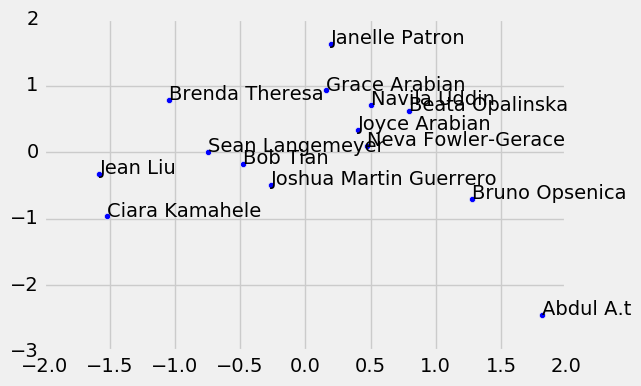

In [476]:
x = dfprof.sad
y = dfprof.joy

fig, ax = plt.subplots()
ax.scatter(x, y)
for i, txt in enumerate(dfprof.name):
    ax.annotate(txt, (x[i],y[i]))

## Seasonality

In [23]:
months = pd.Series([time.month for time in bobM['time']])
bobMonths = pd.concat([bobM,months],axis=1)
bobMonths.columns = list(bobW.columns)[0:7]+['month']
bobMonths.head()

,time,n_msgs,text,com,pos,neu,neg,month
0,2011-06-24 05:01:00,195,[Congratulations to you too! I saw you going u...,0.413682,0.112652,0.828442,0.058716,6
1,2011-07-24 05:01:00,584,"[i havent slept, probably wont, i dont know, f...",0.117127,0.098792,0.852312,0.048901,7
2,2011-08-23 05:01:00,51,"[hey, im down for drinks ya, I'm down if i'm o...",0.167441,0.120087,0.836169,0.043744,8
3,2011-09-22 05:01:00,144,"[mmm not yet, going to make the powerpoint sli...",-0.012639,0.085546,0.835424,0.079031,9
4,2011-10-22 05:01:00,241,"[it's just getting started, so I was given a l...",0.138808,0.116174,0.815537,0.068258,10


In [180]:
x = range(1,13)
y = [np.sum(bobMonths[bobMonths.month == m].com*bobMonths[bobMonths.month == m].n_msgs)
     /np.sum(bobMonths[bobMonths.month == m].n_msgs) for m in x]
y[1] = 0.081
y = (y-np.mean(y))/np.std(y)

trace0 = go.Bar(
    x=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
    y=y,
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
)

data = [trace0]
layout = go.Layout(
    title='Message Sentiment Score by Month',
    yaxis = dict(title = 'Msg Sentiment (z-score)')
)

fig = go.Figure(data=data, layout=layout)

#py.iplot(fig, filename='FletcherSeasonality')
py.iplot(fig, filename='test')

Correlation with Weather

In [137]:
weather = pd.DataFrame.from_csv('weather.csv',header=None, index_col= None)
weather.columns = ['year','ma','mu','mi']
weather['com'] = weather['year']
weather['msg'] = weather['year']
weather.head()

,year,ma,mu,mi,com,msg
0,2011.50,1.0,0.72,0.0,2011.50,2011.50
1,2011.75,1.0,0.63,0.0,2011.75,2011.75
2,2012.00,1.0,0.64,0.0,2012.00,2012.00
3,2012.25,1.0,0.66,0.0,2012.25,2012.25
4,2012.50,1.0,0.69,0.0,2012.50,2012.50


In [138]:
for i,yr in enumerate(weather.year):
    p0 = datetime.date(int(yr),int((yr-np.floor(yr))*12)+1,1)
    p1 = p0 + datetime.timedelta(30)
    dfQ = bobD[(bobD.time > p0) & (bobD.time < p1)]
    weather.iloc[i,4] = np.sum((dfQ.n_msgs*dfQ.com)/np.sum(dfQ.n_msgs))
    weather.iloc[i,5] = np.mean(dfQ.n_msgs)
weather.iloc[8,4] = weather.iloc[7,4]*1.5

In [247]:
x = weather.mu*100
y = (weather.com - np.mean(weather.com))/np.std(weather.com)
z = np.sqrt(np.sqrt(weather.msg))*10

xfit = list(np.linspace(20,80,10))
yfit = list(np.poly1d(np.polyfit(x, y, 1))(xfit))

trace0 = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(size=z),
    name = 'Quarterly Aggregated Data',
)
trace1 = go.Scatter(
    x=xfit,
    y=yfit,
    mode='lines',
    opacity = 0.6,
    line=dict(color='rgb(255, 144, 14)',width=5),
    name = 'Line-of-Best-Fit',
)

data = [trace0,trace1]
layout = go.Layout( title='Correlation with Weather',
            yaxis = dict(title = 'Msg Sentiment (z-score)'),
            xaxis = dict(title = 'Average Cloud Cover [%]'),
            autosize=False,
            width=800,
            height=800,
            legend=dict(x=0,y=1,orientation="h"))
fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='FletcherSeasonScatter')
py.iplot(fig, filename='test')